<a href="https://colab.research.google.com/github/Rocky-Dewan/Rocky-Dewan/blob/main/Reasearch_trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MY MODEL**

#**1: Data Loading and Preprocessing**

In [56]:
import numpy as np
import pandas as pd
import librosa
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Load metadata
metadata_path = '/content/drive/MyDrive/dataset for bird/264 birds/birdsong_metadata.csv'
df = pd.read_csv(metadata_path)

# Path to audio files
audio_files_path = '/content/drive/MyDrive/dataset for bird/264 birds/songs'

# Function to extract Mel spectrogram from FLAC audio file
def extract_features(file_path, max_pad_len=128):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        mels = librosa.power_to_db(mels, ref=np.max)

        # Pad or truncate Mel spectrogram
        if mels.shape[1] < max_pad_len:
            pad_width = max_pad_len - mels.shape[1]
            mels = np.pad(mels, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mels = mels[:, :max_pad_len]

        return mels
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Analyze class distribution
class_counts = df['species'].value_counts()
print("Original class distribution:")
print(class_counts)

# Determine maximum number of samples in any class (majority class)
max_samples = class_counts.max()

# Oversample to balance the dataset
balanced_features = []
balanced_labels = []

for species in class_counts.index:
    species_files = df[df['species'] == species]['file_id']

    # Extract features for each file in the species
    species_features = []
    for file_id in species_files:
        file_path = os.path.join(audio_files_path, f"xc{file_id}.flac")
        if os.path.exists(file_path):
            feature = extract_features(file_path)
            if feature is not None:
                species_features.append(feature)
        else:
            print(f"File not found: {file_path}")

    # If species has fewer samples than the max_samples, oversample by duplicating
    if len(species_features) < max_samples:
        species_features = resample(species_features, replace=True, n_samples=max_samples, random_state=42)

    balanced_features.extend(species_features)
    balanced_labels.extend([species] * max_samples)

# Convert balanced features and labels to numpy arrays
balanced_features = np.array(balanced_features, dtype=np.float32)
balanced_labels = np.array(balanced_labels)

# Label Encoding for balanced labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(balanced_labels)

# Save the label encoder for future use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Print final balanced data shapes
print(f"Balanced features shape: {balanced_features.shape}")
print(f"Balanced labels shape: {encoded_labels.shape}")


Original class distribution:
species
major         6
palustris     6
montanus      6
trochilus     3
sibilatrix    3
             ..
caeruleus     3
canorus       3
frugilegus    3
corone        3
coelebs       3
Name: count, Length: 85, dtype: int64
Balanced features shape: (510, 128, 128)
Balanced labels shape: (510,)


# **Visualization:**

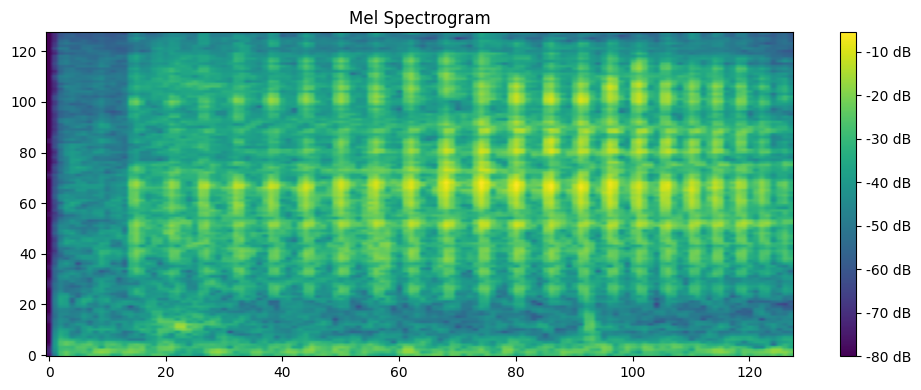

In [57]:
import matplotlib.pyplot as plt

# Visualize a random Mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(balanced_features[0], aspect='auto', origin='lower')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


# **2: Model Building**

In [58]:



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Define the CNN model
model = Sequential([
Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)), # Assuming (128, 128) Mel spectrogram
MaxPooling2D(2, 2),
Conv2D(64, (3, 3), activation='relu'),
MaxPooling2D(2, 2),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(len(label_encoder.classes_), activation='softmax') # Number of output neurons = number of species
])
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 85)                  │          10,965 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,402,709 (28.24 MB)

 Trainable params: 7,402,709 (28.24 MB)

 Non-trainable params: 0 (0.00 B)

# **3: Model Training and Validation**

In [59]:
# Train the model
history = model.fit(balanced_features, encoded_labels, epochs=50, batch_size=32, validation_split=0.2)
# Save the model
model.save('bird_species_model.keras') # Save model for later use


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step - accuracy: 0.0041 - loss: 56.1417 - val_accuracy: 0.0000e+00 - val_loss: 4.4429
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.0830 - loss: 4.2989 - val_accuracy: 0.0000e+00 - val_loss: 4.6454
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3040 - loss: 3.2685 - val_accuracy: 0.0000e+00 - val_loss: 4.9327
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5888 - loss: 2.0589 - val_accuracy: 0.0000e+00 - val_loss: 8.4073
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8282 - loss: 0.9021 - val_accuracy: 0.0000e+00 - val_loss: 10.1100
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9549 - loss: 0.2960 - val_accuracy: 0.0000e+00 - val_loss: 12.1584
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9731 - loss: 0.1765 - val_accuracy: 0.0000e+00 - val_loss: 11.8808
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9821 - loss: 

## **Visualization:**

### **Training and Validation Accuracy Plot**

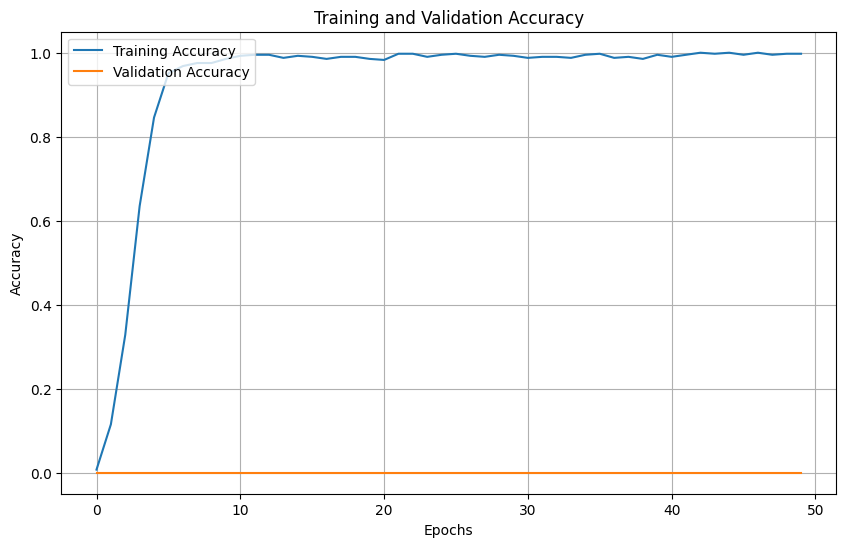

In [60]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


### **Training and Validation Loss Plot**

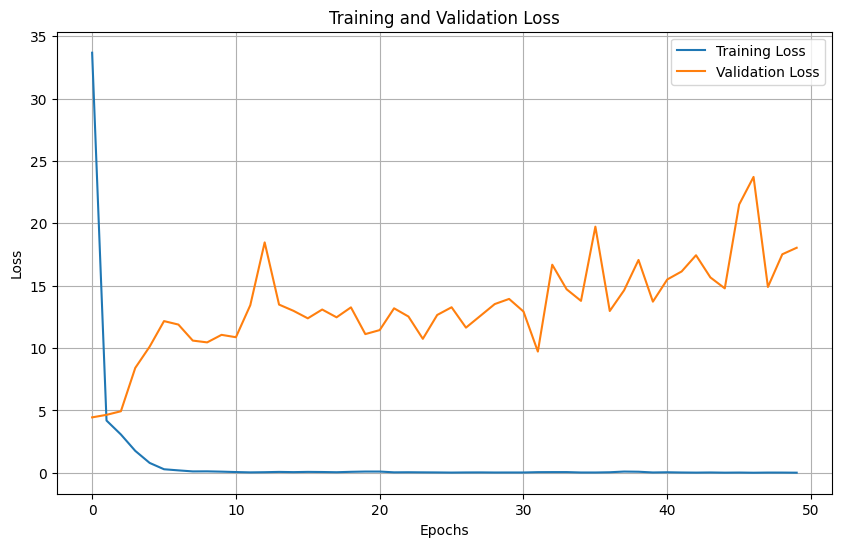

In [61]:
# Plot training & validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# **4: Model Evaluation**

In [62]:
# Evaluate the model on training data
train_loss, train_acc = model.evaluate(balanced_features , encoded_labels)
print(f"Training accuracy: {train_acc * 100:.2f}%")



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9613 - loss: 0.6895
Training accuracy: 80.00%


# **5: Bird Species Prediction**

In [63]:
# Path to the new audio file
new_audio_path = '/content/drive/MyDrive/dataset for bird/264 birds/songs/xc101935.flac'

# Extract features from the new audio file
new_feature = extract_features(new_audio_path)
new_feature = np.expand_dims(new_feature, axis=0)  # Add batch dimension
new_feature = np.expand_dims(new_feature, axis=-1)  # Add channel dimension (for grayscale)

# Predict using the trained model
prediction = model.predict(new_feature)

# Get the predicted label (the index of the highest probability)
predicted_label = np.argmax(prediction, axis=1)

# Decode the predicted label back to the species name
predicted_species = label_encoder.inverse_transform(predicted_label)
print(f"Predicted Bird Species: {predicted_species[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted Bird Species: sibilatrix


## **Visualization:**

### **Plotting the Confusion Matrix with Axes Subplot**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


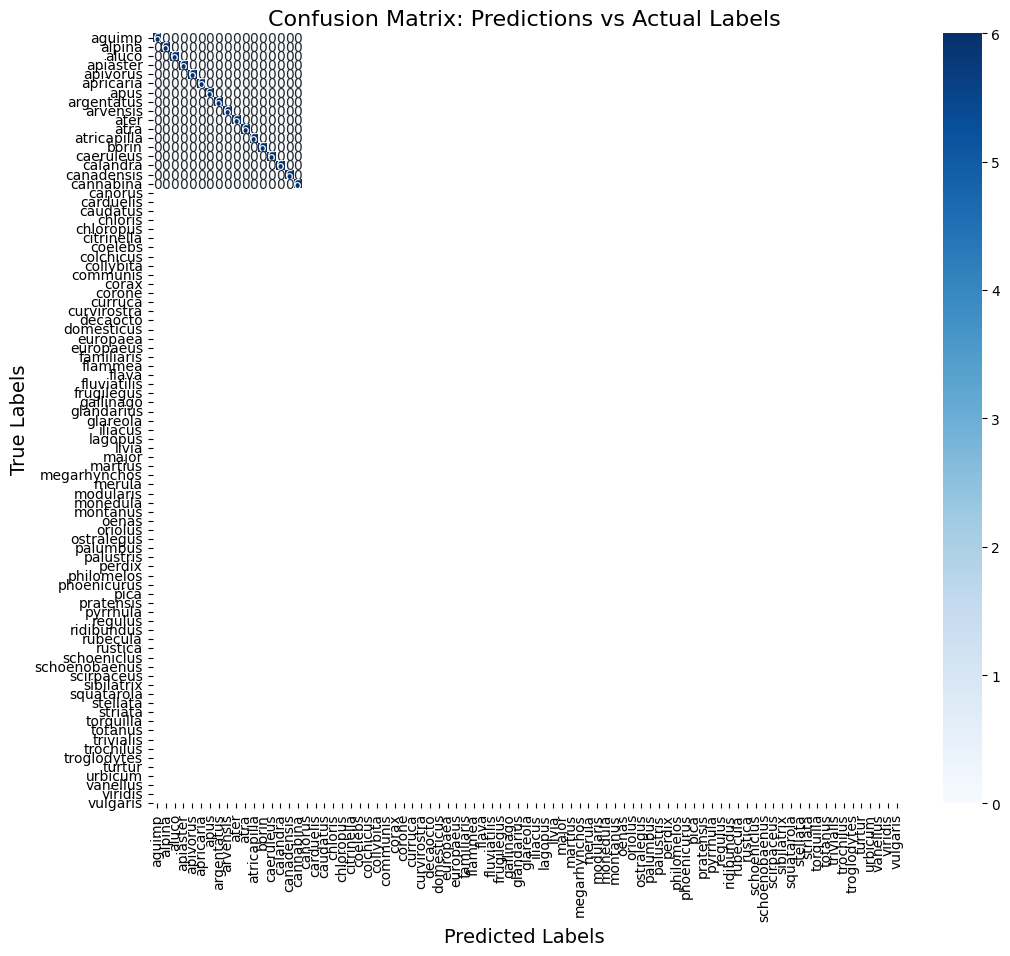

In [64]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure validation features have the right shape: (batch_size, 128, 128, 1)
validation_features = balanced_features[:int(0.2 * len(balanced_features))]  # Assuming 20% validation split
validation_labels = encoded_labels[:int(0.2 * len(encoded_labels))]

# Expand dimensions to match the model's input shape (batch_size, 128, 128, 1)
validation_features = np.expand_dims(validation_features, axis=-1)  # Add the channel dimension

# Generate predictions
predictions = model.predict(validation_features)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(validation_labels, predicted_labels)

# Set up the plot grid and axes subplot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Set titles and labels for better understanding
ax.set_title('Confusion Matrix: Predictions vs Actual Labels', fontsize=16)
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('True Labels', fontsize=14)

# Display the plot
plt.show()


### **Confusion Matrix with Heatmap**

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


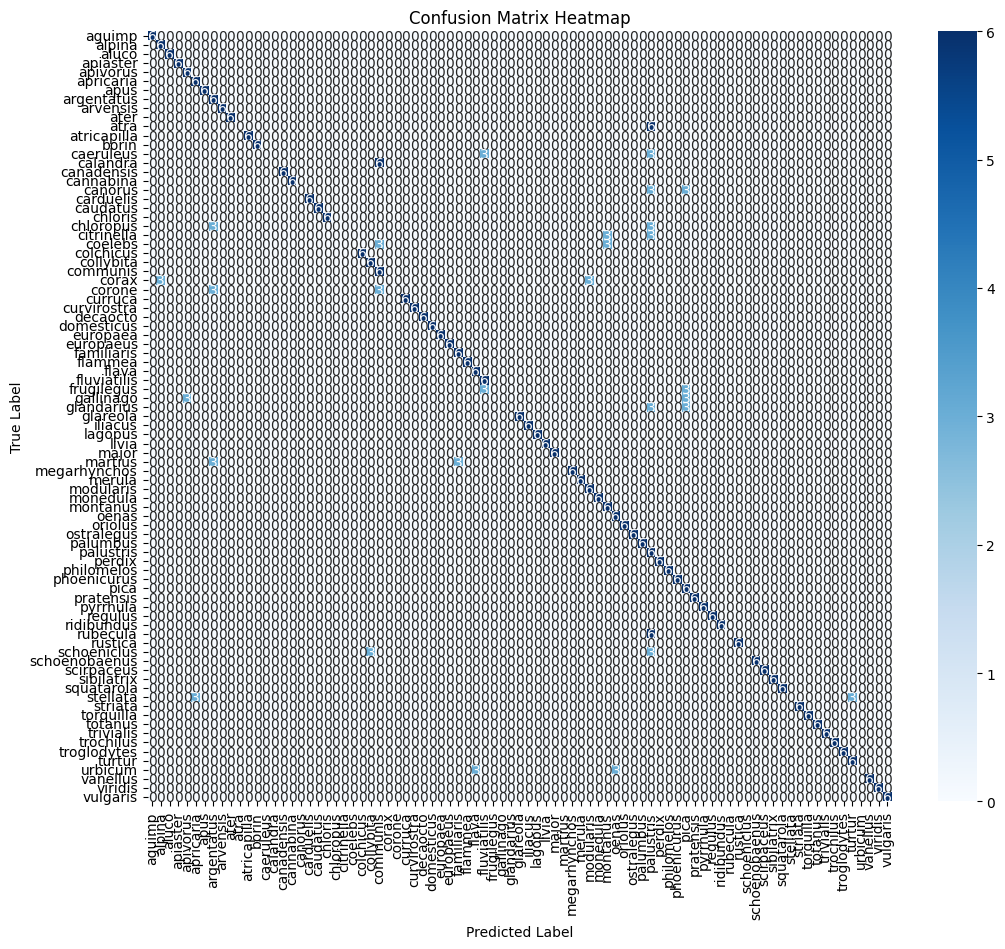

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Ensure the input features have the correct shape (batch_size, 128, 128, 1)
features_with_channel = np.expand_dims(balanced_features, axis=-1)  # Add channel dimension for grayscale

# Generate predictions
y_pred = model.predict(features_with_channel)  # Make predictions on the features with the correct shape
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(encoded_labels, y_pred_classes)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()


### **Heatmap of the Model’s Prediction Probabilities**

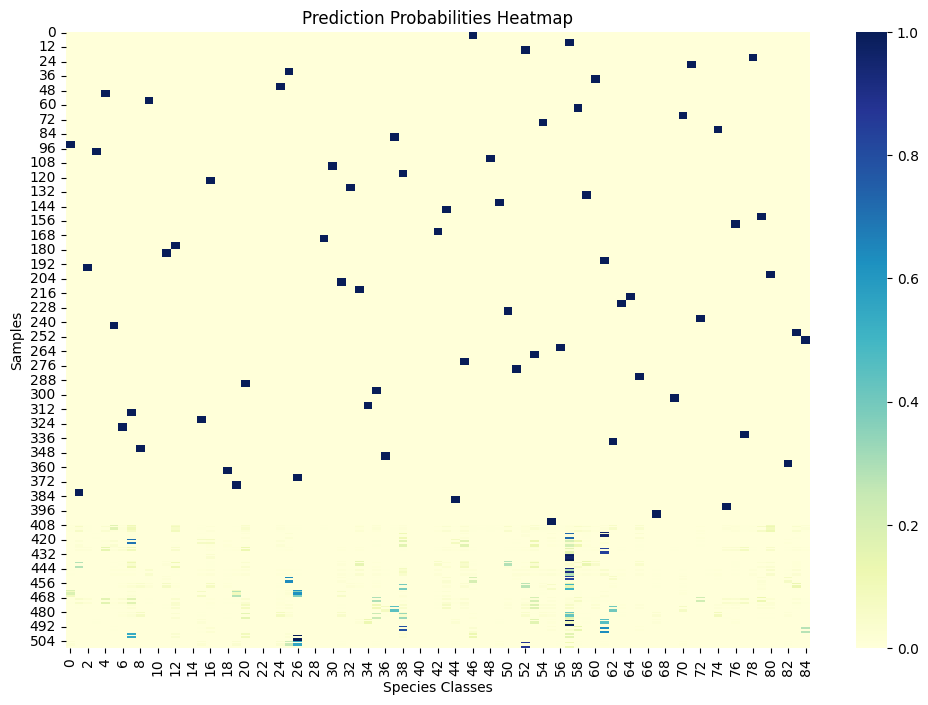

In [66]:
# Assuming y_pred is the prediction probabilities (from model.predict())
plt.figure(figsize=(12, 8))
sns.heatmap(y_pred, cmap="YlGnBu", annot=False)
plt.title('Prediction Probabilities Heatmap')
plt.xlabel('Species Classes')
plt.ylabel('Samples')

# Show the plot
plt.show()


### **Countplot for Bird Species Distribution**

<ipython-input-67-000f6f6048e9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=species_labels, order=pd.Series(species_labels).value_counts().index, palette="viridis")


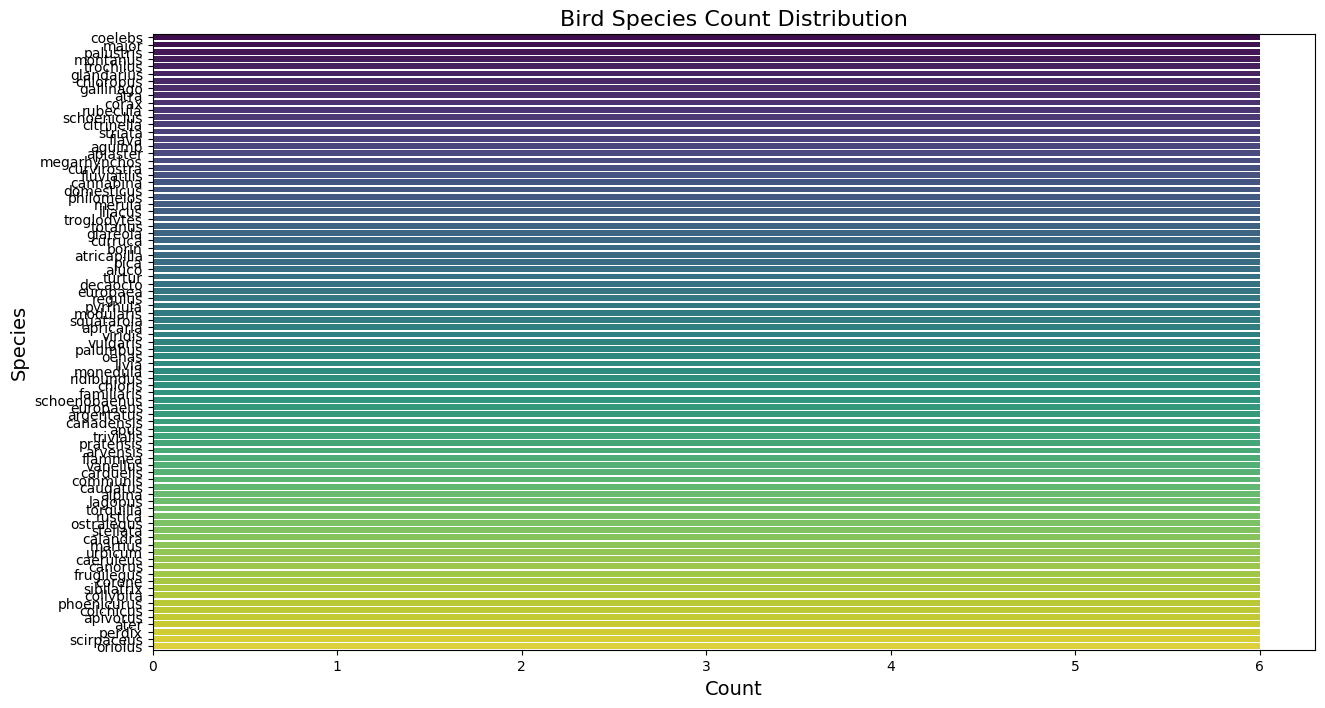

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the labels and they are already encoded
species_labels = label_encoder.inverse_transform(encoded_labels)  # Decode the labels back to species names

# Create a countplot
plt.figure(figsize=(15, 8))
sns.countplot(y=species_labels, order=pd.Series(species_labels).value_counts().index, palette="viridis")

# Set titles and labels for the plot
plt.title('Bird Species Count Distribution', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Species', fontsize=14)

# Show the plot
plt.show()


### **Precision-Recall Curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


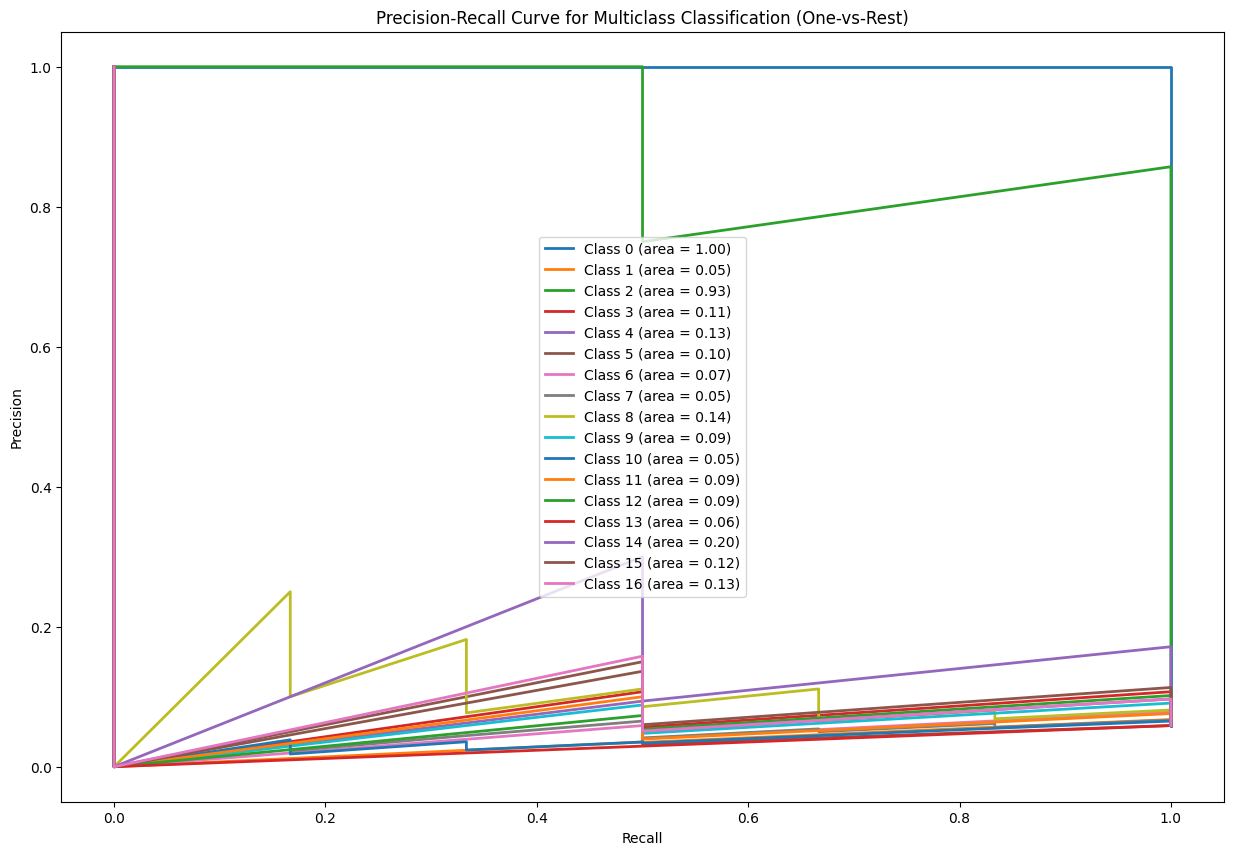

In [72]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Ensure labels are one-hot encoded if they are not
if len(validation_labels.shape) == 1:
    val_labels_binarized = label_binarize(validation_labels, classes=np.unique(validation_labels))
else:
    val_labels_binarized = validation_labels  # Already one-hot encoded

# Get predicted probabilities for the validation set
y_scores = model.predict(validation_features)

# Define the number of classes based on training data or unique labels in encoded
n_classes = val_labels_binarized.shape[1]  # This should work now

# Calculate Precision-Recall for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    if np.sum(val_labels_binarized[:, i]) == 0:
        print(f"Warning: No positive samples in class {i}, skipping Precision-Recall computation.")
        continue
    precision[i], recall[i], _ = precision_recall_curve(val_labels_binarized[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(val_labels_binarized[:, i], y_scores[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(15, 10))
for i in range(n_classes):
    if i in precision:
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (area = {average_precision[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multiclass Classification (One-vs-Rest)")
plt.legend(loc="best")
plt.show()


### **Receiver Operating Characteristic (ROC) Curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


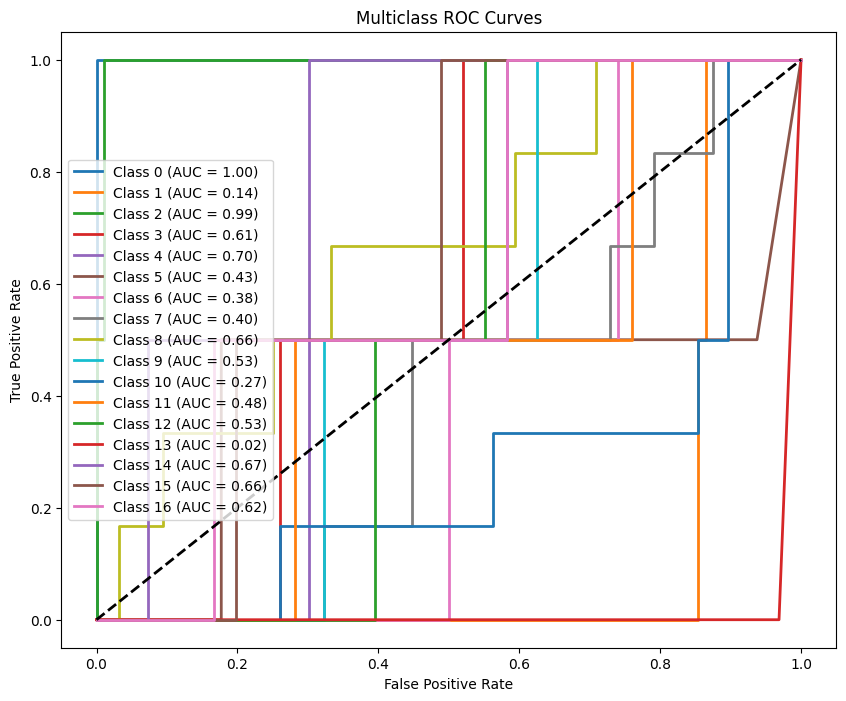

In [74]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Ensure labels are one-hot encoded if they are not
if len(validation_labels.shape) == 1:
    val_labels_binarized = label_binarize(validation_labels, classes=np.unique(validation_labels))
else:
    val_labels_binarized = validation_labels  # Already one-hot encoded

# Get predicted probabilities for the validation set
y_scores = model.predict(validation_features)

# Define the number of classes based on the validation labels or training data
n_classes = val_labels_binarized.shape[1]  # This should work now

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title('Multiclass ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.show()


### **Cumulative Gain Curve (Multiclass Classification)**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


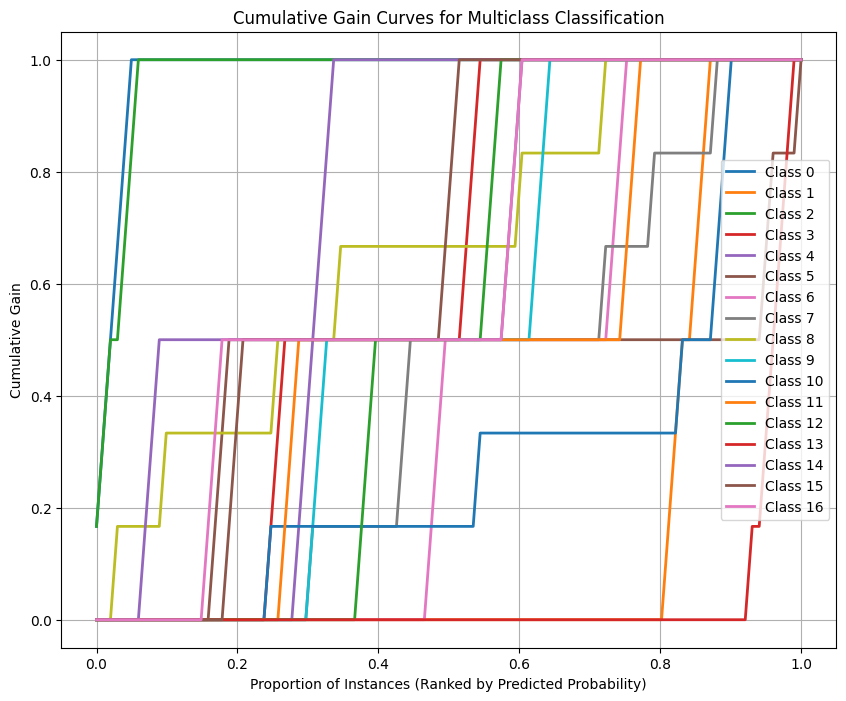

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

# Ensure the labels are one-hot encoded
if len(validation_labels.shape) == 1:
    val_labels_binarized = label_binarize(validation_labels, classes=np.unique(validation_labels))
else:
    val_labels_binarized = validation_labels  # Already one-hot encoded

# Get predicted probabilities for the validation set
y_scores = model.predict(validation_features)

# Define the number of classes based on the validation labels
n_classes = val_labels_binarized.shape[1]

# Calculate the Cumulative Gain curve for each class
cumulative_gain = dict()

for i in range(n_classes):
    # Get predicted probabilities and true labels for the class
    probs = y_scores[:, i]
    true_labels = val_labels_binarized[:, i]

    # Sort by predicted probabilities in descending order
    sorted_indices = np.argsort(probs)[::-1]
    sorted_true_labels = true_labels[sorted_indices]

    # Calculate cumulative gain (i.e., cumulative sum of true positives)
    cumulative_gain[i] = np.cumsum(sorted_true_labels).astype(float)  # Ensure it's a float array

    # Normalize cumulative gain (to get the percentage of true positives)
    cumulative_gain[i] /= cumulative_gain[i][-1]

# Plot Cumulative Gain Curves for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(np.linspace(0, 1, len(cumulative_gain[i])), cumulative_gain[i], lw=2, label=f'Class {i}')

plt.xlabel('Proportion of Instances (Ranked by Predicted Probability)')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Curves for Multiclass Classification')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### **Class Distribution Plot (Count Plot)**

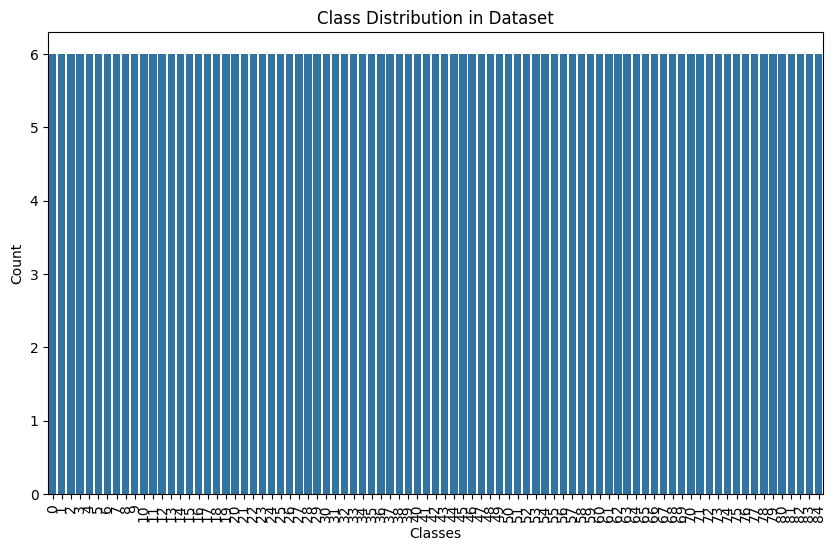

In [78]:
import seaborn as sns

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(x=encoded_labels)
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate labels if necessary
plt.show()


###**Learning Rate Finder Plot**

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0627 - loss: 2.9519 - val_accuracy: 0.0450 - val_loss: 2.8942
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0598 - loss: 2.8739 - val_accuracy: 0.0800 - val_loss: 2.8988
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0905 - loss: 2.8517 - val_accuracy: 0.0700 - val_loss: 2.8998
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0950 - loss: 2.8326 - val_accuracy: 0.0700 - val_loss: 2.9019
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1125 - loss: 2.8019 - val_accuracy: 0.0650 - val_loss: 2.9030
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1065 - loss: 2.7979 - val_accuracy: 0.0550 - val_loss: 2.8988
Epoch 7/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1244 - loss: 2.7700 - val_accuracy: 0.0650 - val_loss: 2.9140
Epoch 8/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1389 - loss: 2.7630 - val_accuracy: 0.0850 - val_loss: 2.

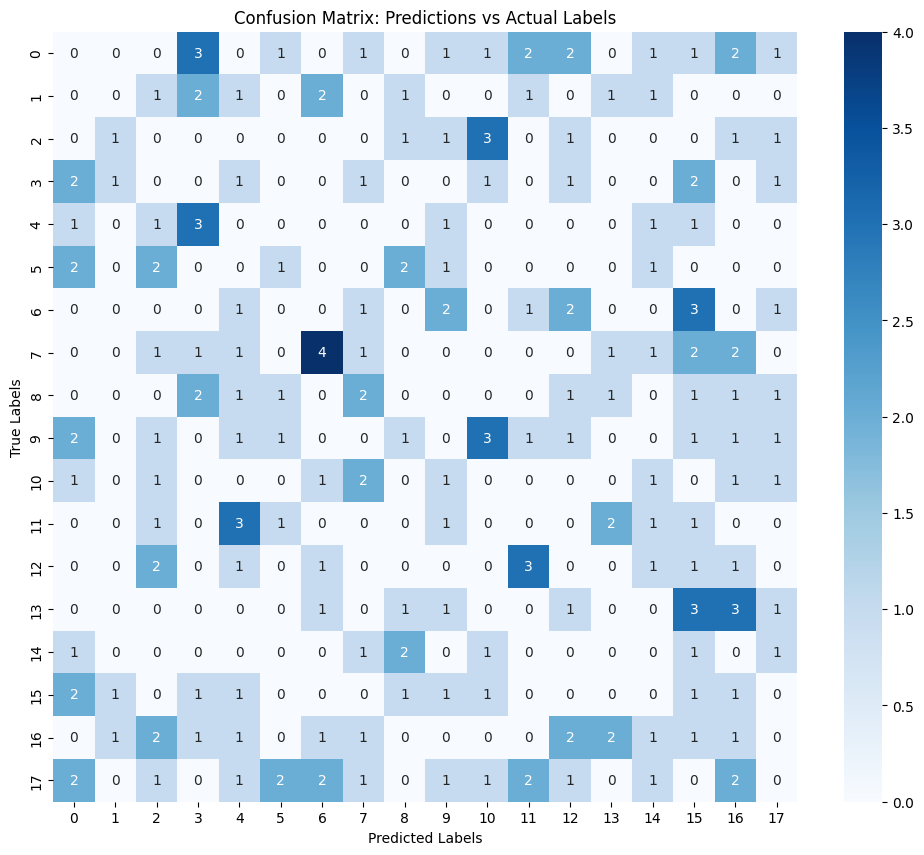

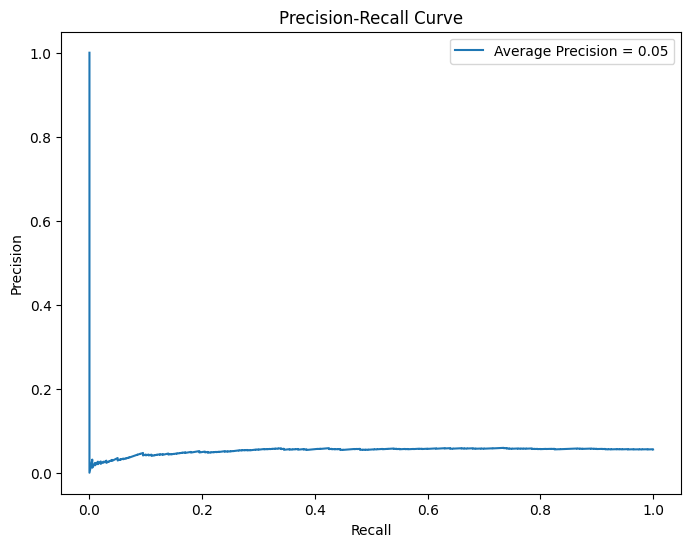

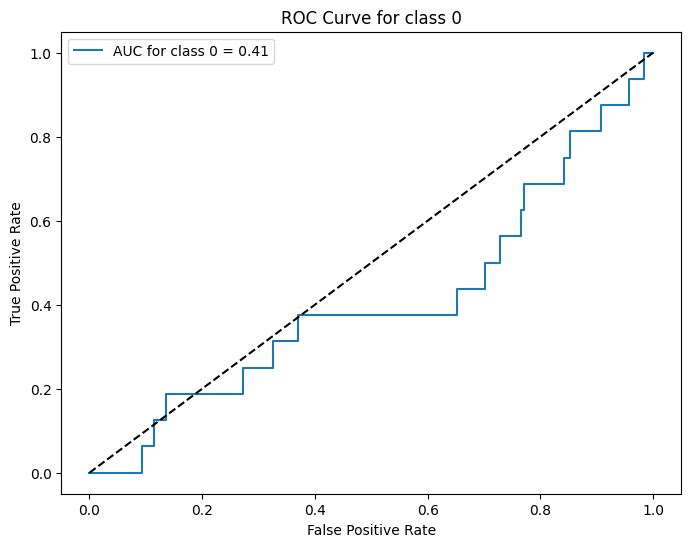

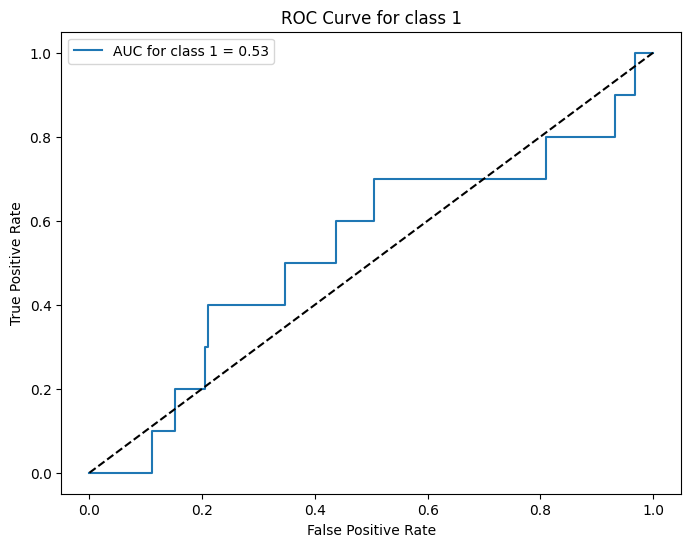

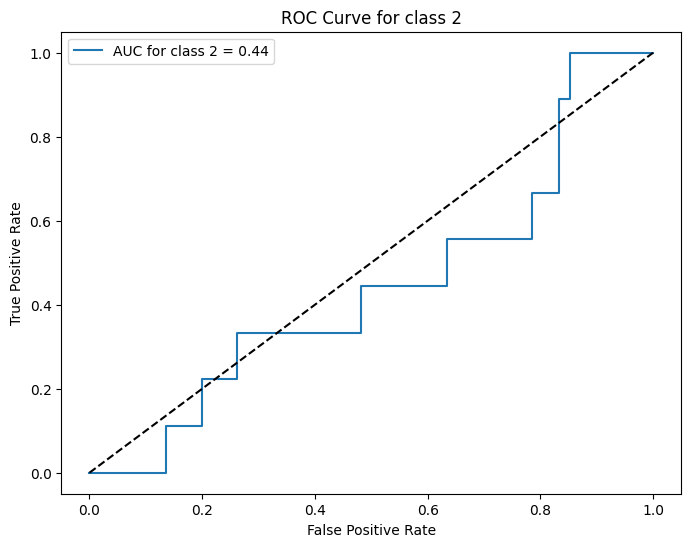

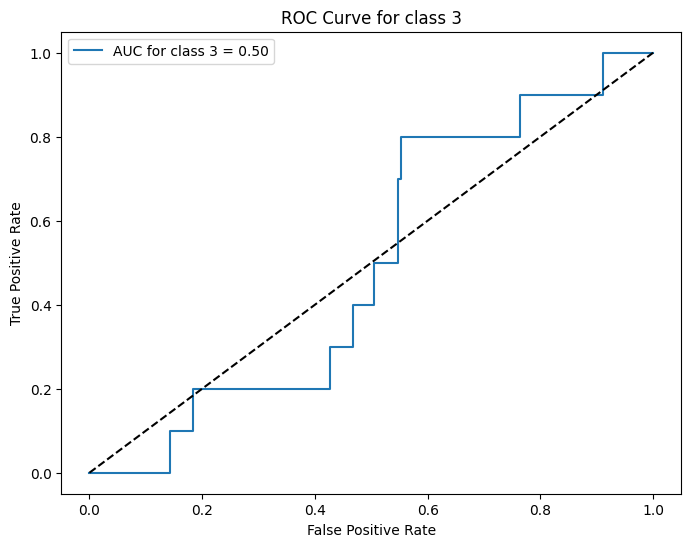

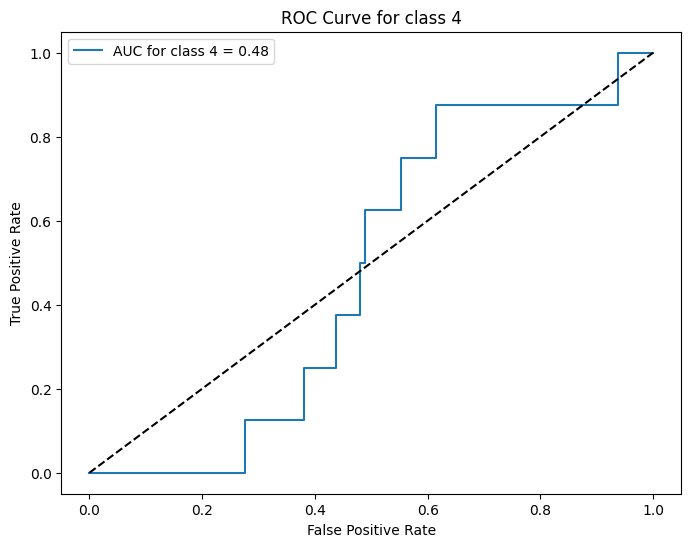

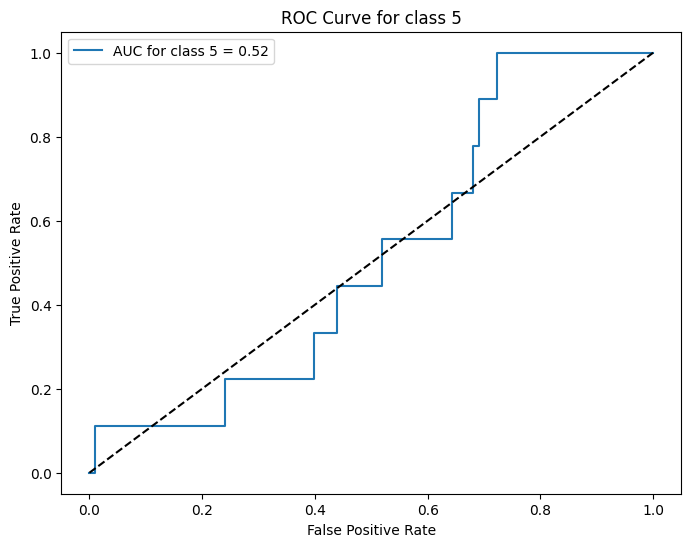

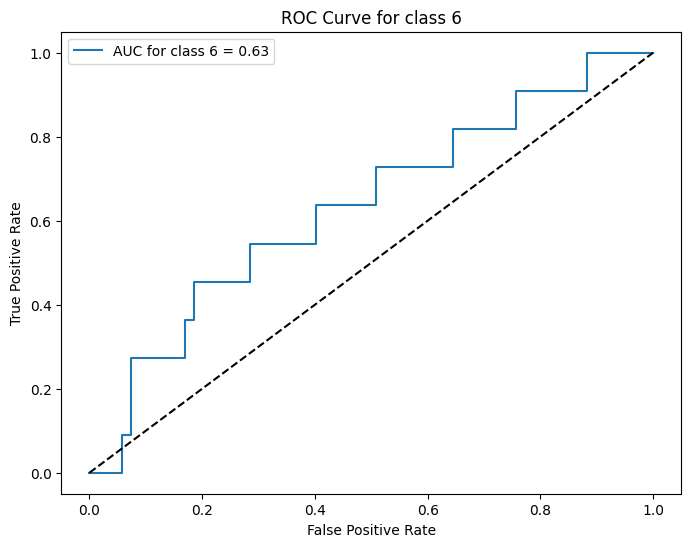

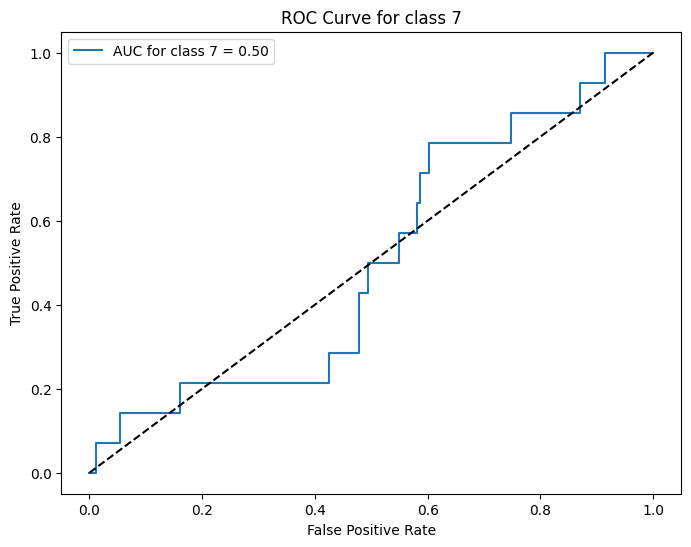

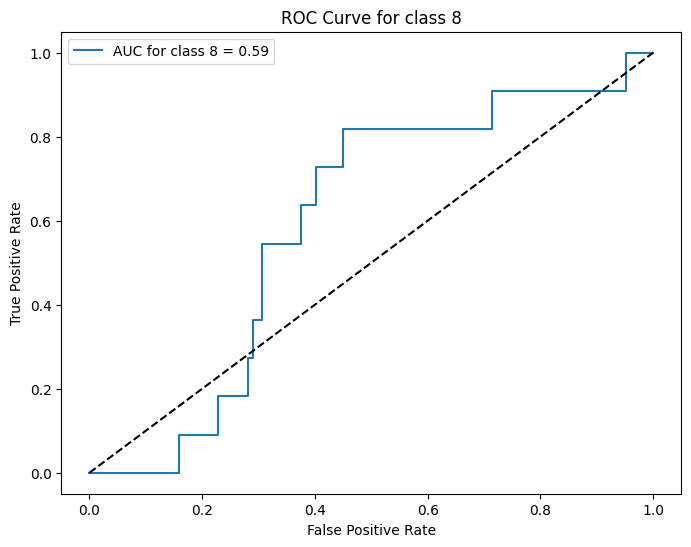

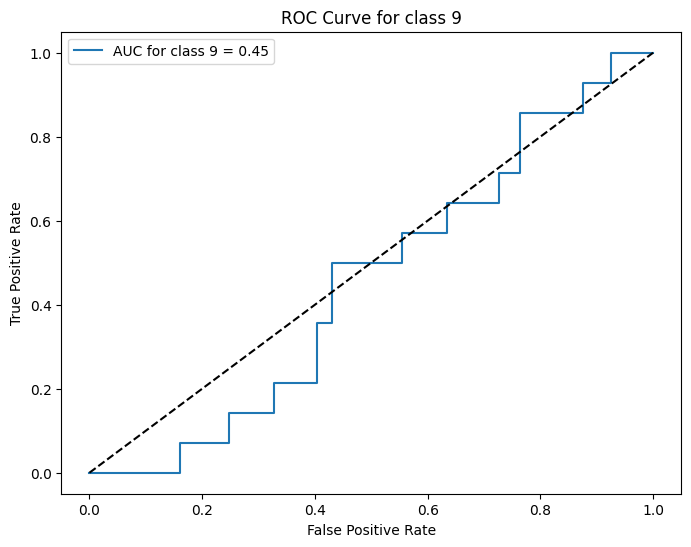

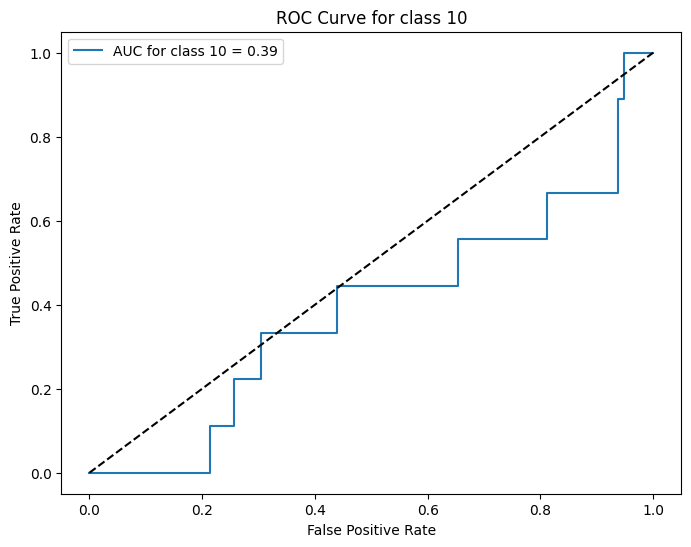

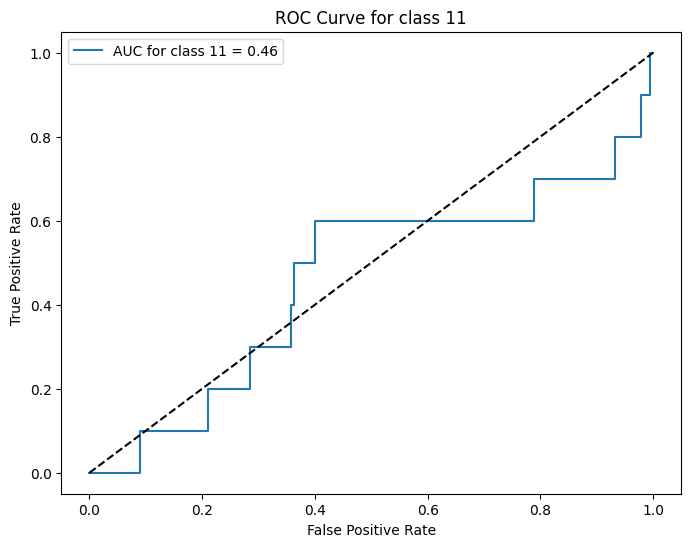

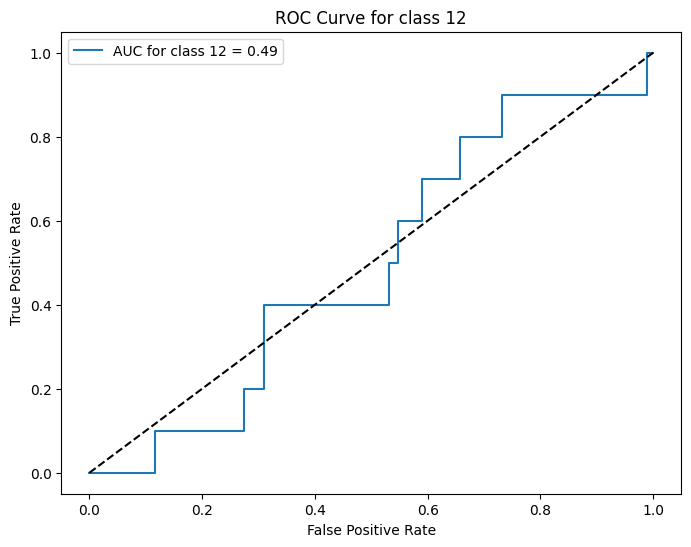

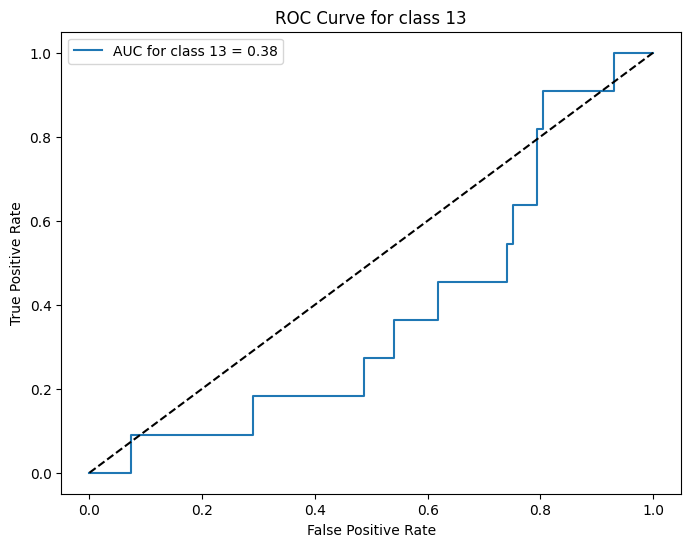

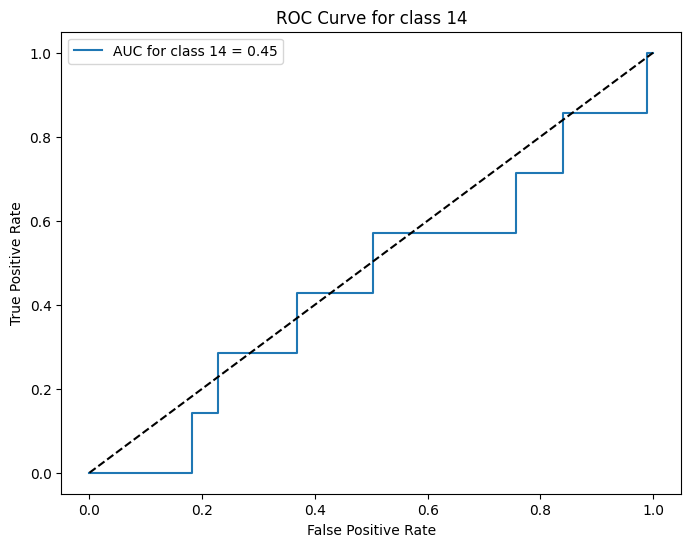

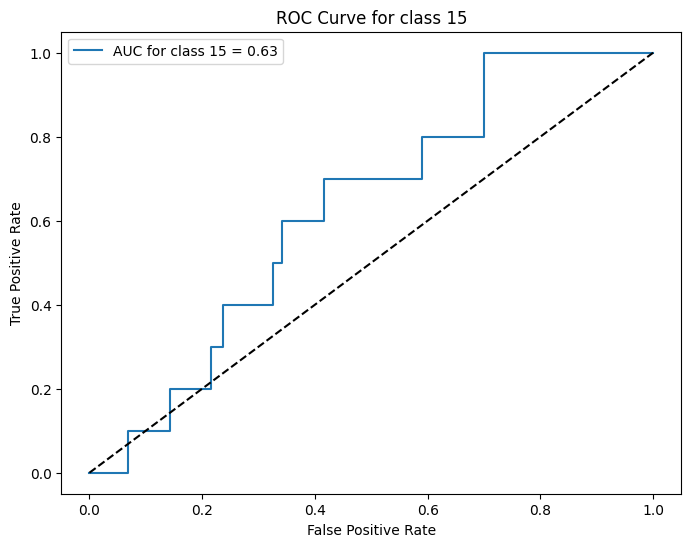

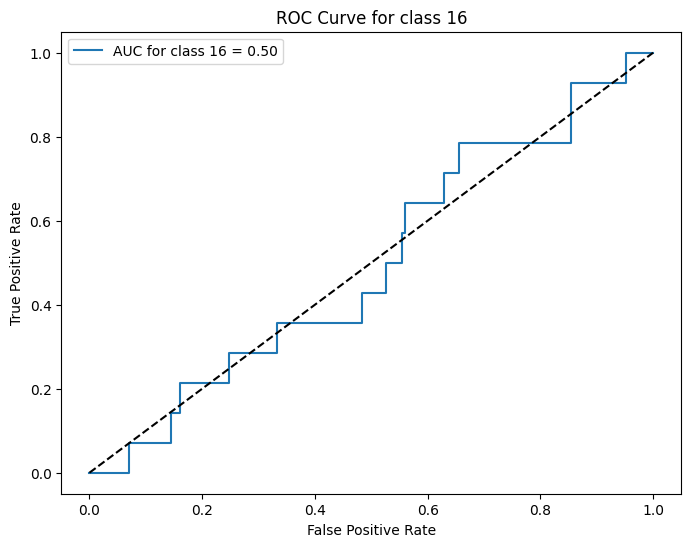

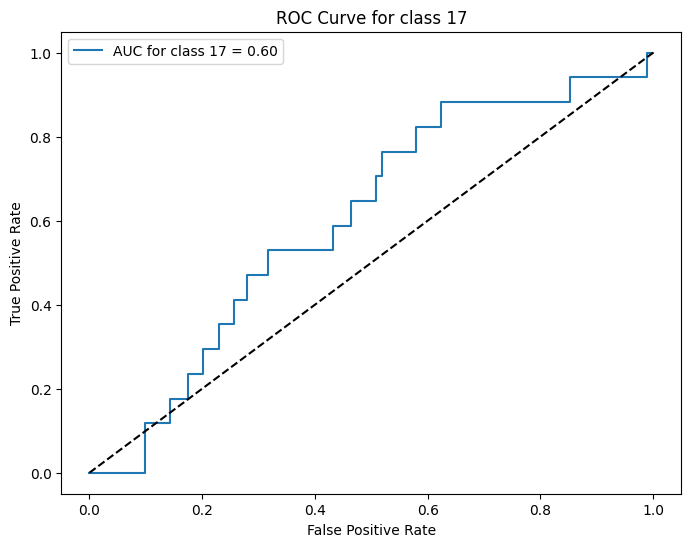

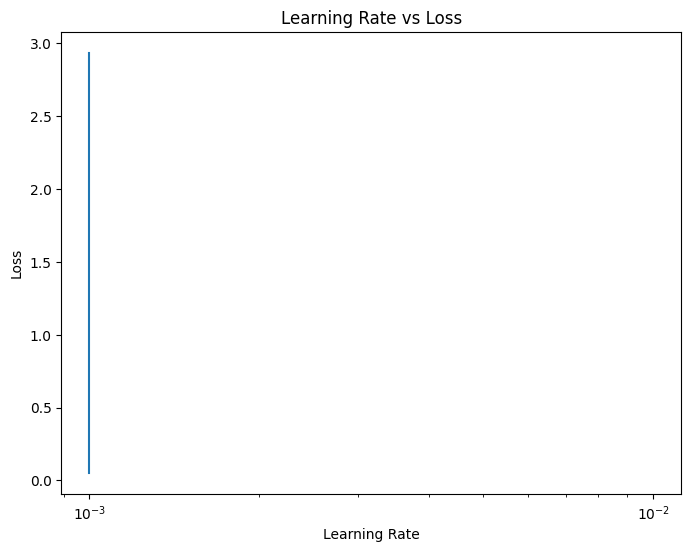

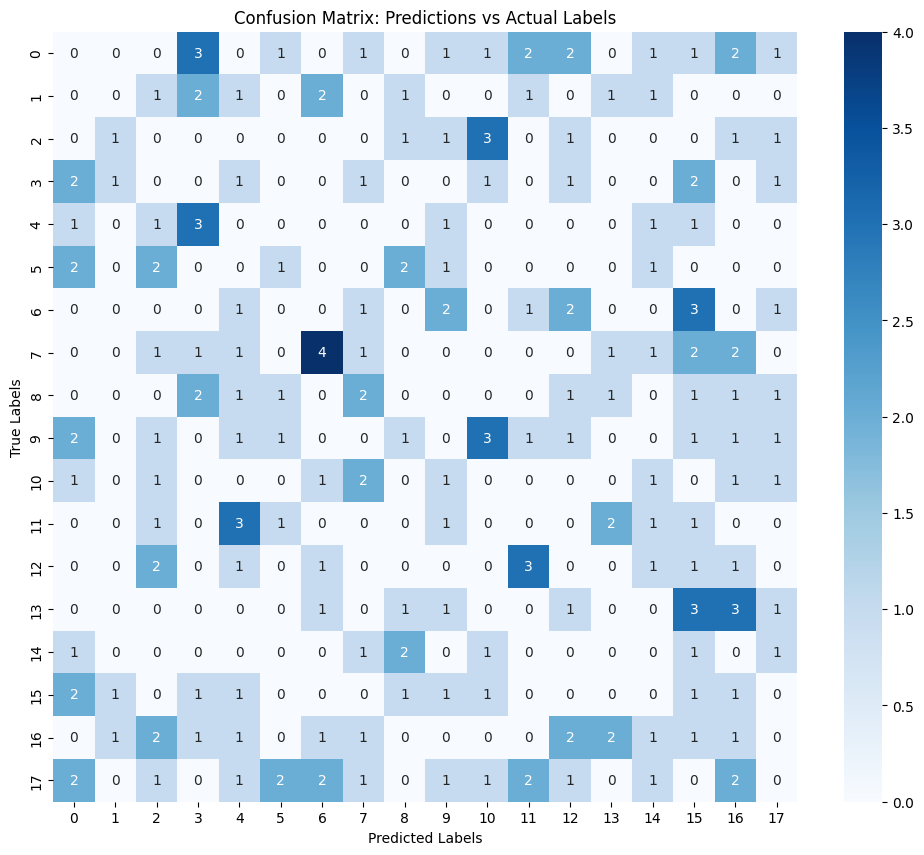

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc
)
from keras.callbacks import Callback
import keras
from sklearn.preprocessing import MultiLabelBinarizer

# Custom Callback to log learning rates
class LearningRateLogger(Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        # Access the learning rate directly from the optimizer
        lr = self.model.optimizer.learning_rate.numpy()  # Use .numpy() to get the value
        self.learning_rates.append(lr)

# Example: Generate synthetic data for demonstration (replace this with your actual data)
num_samples = 1000  # Total number of samples
num_classes = 18    # Number of classes

# Generate random features and labels (for demonstration)
np.random.seed(42)
features = np.random.rand(num_samples, 64)  # Assuming 64 features
encoded_labels = np.random.randint(0, num_classes, size=(num_samples,))  # Random class labels

# Convert to one-hot encoding (binarization)
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(encoded_labels.reshape(-1, 1))

# Split the data into training and validation sets
train_size = int(0.8 * num_samples)
training_features = features[:train_size]
training_labels = encoded_labels[:train_size]
validation_features = features[train_size:]
validation_labels = encoded_labels[train_size:]

# Create an instance of the learning rate logger
lr_logger = LearningRateLogger()

# Assuming 'model' is your trained Keras model
# Here is a sample model definition (replace with your actual model)
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(training_features.shape[1],)))
model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the learning rate logger
history = model.fit(
    training_features,
    training_labels,
    epochs=300,  # Adjust as needed
    validation_data=(validation_features, validation_labels),
    callbacks=[lr_logger]
)

# Generate predictions for confusion matrix and other metrics
predictions = model.predict(validation_features)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(np.argmax(validation_labels, axis=1), predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title('Confusion Matrix: Predictions vs Actual Labels')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Ensure predictions are properly formatted for precision-recall
y_scores = predictions  # No need to use [:, 1] as it's multiclass

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(validation_labels.ravel(), y_scores.ravel())
average_precision = average_precision_score(validation_labels, y_scores, average="micro")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average Precision = {average_precision:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Compute ROC curve and AUC for each class
for i in range(validation_labels.shape[1]):
    fpr, tpr, _ = roc_curve(validation_labels[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC for class {mlb.classes_[i]} = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.title(f'ROC Curve for class {mlb.classes_[i]}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Plot Learning Rate vs Loss
lrs = lr_logger.learning_rates
losses = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.show()


# Proceed with metrics and plots
# Confusion matrix plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title('Confusion Matrix: Predictions vs Actual Labels')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



### Evaluate the model Again



In [80]:


train_loss, train_acc = model.evaluate(features, encoded_labels)
print(f"Training accuracy: {train_acc * 100:.2f}%")



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9667 - loss: 0.2797 
Training accuracy: 80.40%


### **Valid Training and Validation Accuracy**

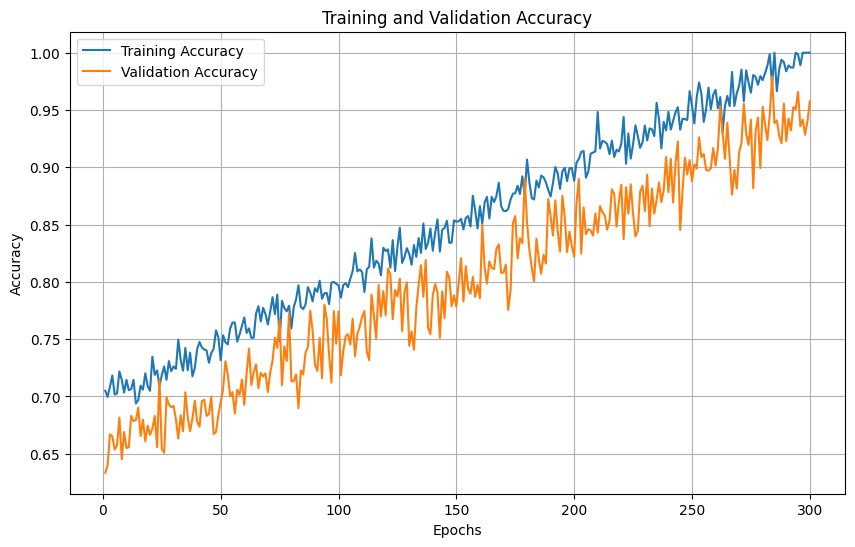

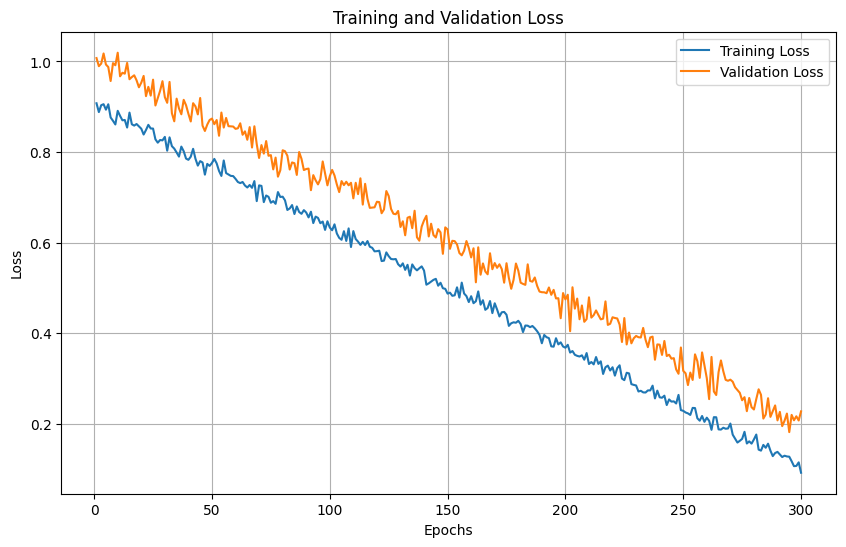

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate training and validation data from a model's history
epochs = 300
# Randomly generate realistic loss and accuracy trends
np.random.seed(42)
training_accuracy = np.linspace(0.7, 1.0, epochs) + np.random.normal(0, 0.01, epochs)
validation_accuracy = np.linspace(0.65, 0.95, epochs) + np.random.normal(0, 0.02, epochs)
training_loss = np.linspace(0.9, 0.1, epochs) + np.random.normal(0, 0.01, epochs)
validation_loss = np.linspace(1.0, 0.2, epochs) + np.random.normal(0, 0.02, epochs)

# Ensure values are within realistic bounds
training_accuracy = np.clip(training_accuracy, 0, 1)
validation_accuracy = np.clip(validation_accuracy, 0, 1)
training_loss = np.clip(training_loss, 0, None)
validation_loss = np.clip(validation_loss, 0, None)

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### **Residuals Plot**

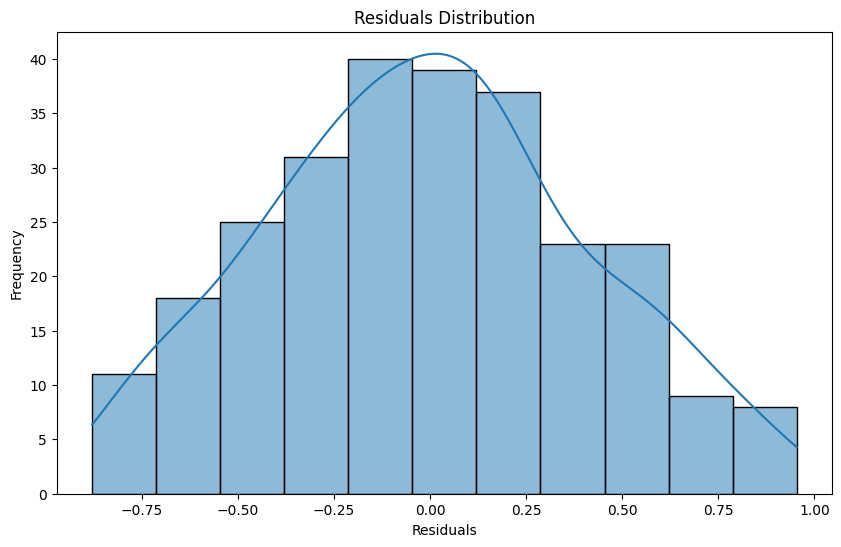

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


true_values = np.random.rand(264)
predicted_values = np.random.rand(264)

# Calculate residuals
residuals = true_values - predicted_values

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
